# Setup enviorment

In [ ]:
%cd ..

In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/variational_autoencoder_Per_Band/224_band10.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

### Train Test split

In [5]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)


### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0         1         2         3         4         5  \
41001 201546 -0.253647 -0.360456  0.178734 -0.140726 -0.172394 -0.209797   
      201547  0.463362 -0.174521 -0.516464 -0.194567 -0.394375 -0.445194   
      201548 -0.533946 -0.186941  0.263531 -0.524311 -0.087354 -0.327959   
      201549  0.008594 -0.420381 -0.000341 -0.212497  0.252161 -0.068546   
      201550 -0.008702  0.129467 -0.809570  0.427478 -0.200123  0.206409   

                     6         7         8         9  ...      1015      1016  \
41001 201546  0.050970  0.358259  0.205635 -0.222807  ...  0.042459 -0.110209   
      201547  0.447911  0.000778  0.496331 -0.369553  ...  0.217010  0.150917   
      201548 -0.223819 -0.353693 -0.276157  0.115399  ... -0.200156  0.319184   
      201549  0.291697  0.585674 -0.138329 -0.175007  ...  0.204320 -0.304361   
      201550 -0.162483 -0.197473  0.314346 -0.103339  ...  0.465220  0.324374   

                  1017      1018      1019      1020      1021      1022  \
41001 201546  0.042641  0.086008  0.622627  0.240003 -0.807739 -0.628060   
      201547 -0.266826 -0.644536  0.186007  0.073047  0.205309  0.315845   
      201548  0.287334 -0.710145  0.512379 -0.257695  0.128910  0.169231   
      201549  0.094129 -0.360204  0.399680  0.305004 -0.163448 -0.558466   
      201550 -0.541347 -0.636560  0.194321  0.734432 -0.674461 -0.475240   

                  1023    Labels  
41001 201546  0.410430 -0.861740  
      201547 -0.140510 -0.854589  
      201548 -0.180297 -0.856973  
      201549 -0.290006 -0.856973  
      201550  0.133749 -0.823600  

[5 rows x 1025 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0         1         2         3         4         5  \
41001 201820 -0.001806 -0.024036  0.326278 -0.182463  0.085932 -0.037617   
      201821  0.309534 -0.213099  0.758807 -0.531174 -0.226123  0.297260   
      201822  0.373954  0.101099 -0.010006  0.341602  0.383082 -0.340898   
      201823  0.386315 -0.352129  0.400594 -0.164775 -0.195453  0.218161   
      201824  0.359385 -0.095758  0.000893  0.340870  0.014474 -0.175544   

                     6         7         8         9  ...      1015      1016  \
41001 201820  0.048654  0.548764 -0.036000 -0.146117  ... -0.488803 -0.541177   
      201821 -0.425894 -0.003840 -0.000757  0.507397  ... -0.425164  0.128963   
      201822  0.188903 -0.378039  0.571008  0.230897  ... -0.075928 -0.456772   
      201823  0.413178 -0.394050 -0.035858 -0.677189  ... -0.190806  0.206382   
      201824  0.121478 -0.202238  0.016610 -0.788359  ... -0.119631 -0.334818   

                  1017      1018      1019      1020      1021      1022  \
41001 201820  0.434727 -0.061277  0.330240 -0.226248  0.309404 -0.497388   
      201821 -0.037223  0.177938 -0.166712  0.760683 -0.324541 -0.152458   
      201822  0.095952 -0.193494  0.176361 -0.176957  0.043487  0.031921   
      201823 -0.309704 -0.099466  0.103420 -0.293662 -0.238592 -0.036521   
      201824  0.436687  0.053248  0.298406 -0.592983 -0.322919 -0.012991   

                  1023    Labels  
41001 201820  0.358281 -0.949940  
      201821  0.070381 -0.961859  
      201822  0.010568 -0.940405  
      201823 -0.801414 -0.961859  
      201824  0.231938 -0.954708  

[5 rows x 1025 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(130, 1025)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [11]:
train.shape

(1300, 1025)

### Features and Labels Set

In [12]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1300, 1024)
The shape of the labels is (1300, 1)
Test:
The shape of the features is (330, 1024)
The shape of the labels is (330, 1)


In [13]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

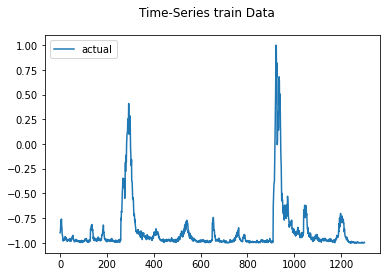

2023-03-14 15:36:41.937896: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-14 15:36:41.937947: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-14 15:36:41.937987: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-14 15:36:41.938260: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 15:36:42.053232: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Test MAE: 45.905
Test RMSE: 55.320
Test sMAPE: 102.780
Test R Squared: -2.167
{'mae': 45.90537211786617, 'rmse': 55.320150768652596, 'smape': 102.78047762431952, 'r2': -2.166713049900255}


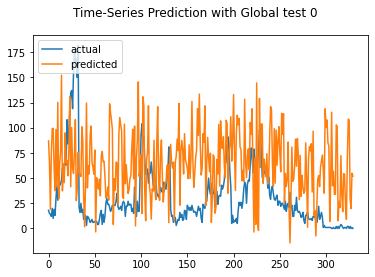

Test MAE: 48.016
Test RMSE: 56.203
Test sMAPE: 105.112
Test R Squared: -2.269
{'mae': 48.01554397669705, 'rmse': 56.20333388894089, 'smape': 105.11151165264997, 'r2': -2.2686329742529288}


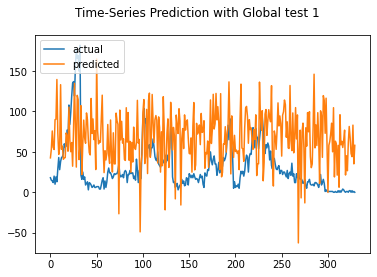

Test MAE: 46.657
Test RMSE: 55.473
Test sMAPE: 104.303
Test R Squared: -2.184
{'mae': 46.65741437565197, 'rmse': 55.473369768349336, 'smape': 104.30341689330486, 'r2': -2.1842788925012555}


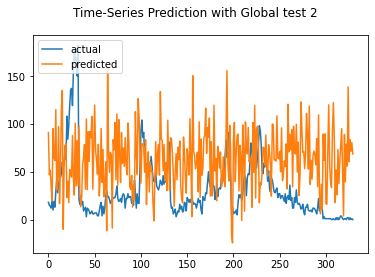

Test MAE: 36.047
Test RMSE: 46.464
Test sMAPE: 103.987
Test R Squared: -1.234
{'mae': 36.047025711608654, 'rmse': 46.46446361687516, 'smape': 103.98699362248189, 'r2': -1.234003544060994}


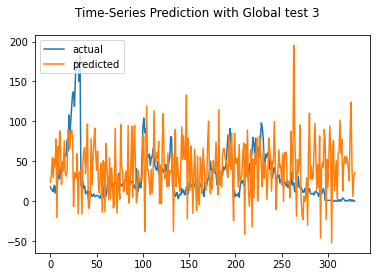

Test MAE: 43.712
Test RMSE: 53.533
Test sMAPE: 104.590
Test R Squared: -1.965
{'mae': 43.71165939713969, 'rmse': 53.5325157607886, 'smape': 104.59018548186053, 'r2': -1.965359205939388}


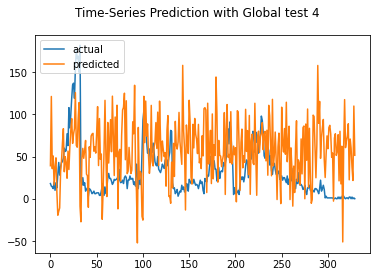

Test MAE: 56.929
Test RMSE: 65.629
Test sMAPE: 108.976
Test R Squared: -3.457
{'mae': 56.929467513705745, 'rmse': 65.62919372706948, 'smape': 108.97646368345882, 'r2': -3.456933347846485}


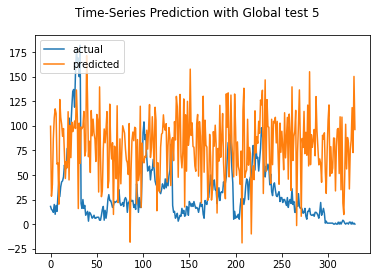

Test MAE: 47.525
Test RMSE: 56.375
Test sMAPE: 106.733
Test R Squared: -2.289
{'mae': 47.52484639774669, 'rmse': 56.374991731780646, 'smape': 106.7331512823489, 'r2': -2.288629771231775}


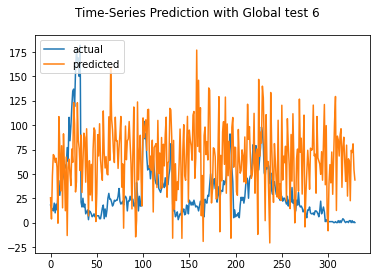

Test MAE: 44.718
Test RMSE: 54.880
Test sMAPE: 103.799
Test R Squared: -2.117
{'mae': 44.717887324817255, 'rmse': 54.87985862108498, 'smape': 103.79894246314194, 'r2': -2.1165060150645045}


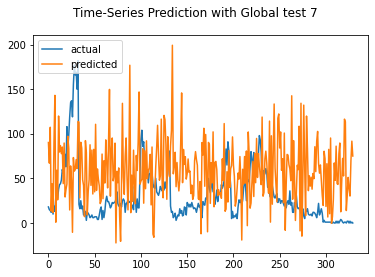

Test MAE: 34.155
Test RMSE: 43.961
Test sMAPE: 98.884
Test R Squared: -1.000
{'mae': 34.15485557967966, 'rmse': 43.9610668760574, 'smape': 98.88443881860177, 'r2': -0.9997626325141331}


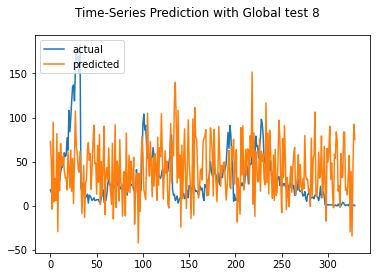

Test MAE: 53.406
Test RMSE: 61.936
Test sMAPE: 105.858
Test R Squared: -2.969
{'mae': 53.40559508078026, 'rmse': 61.936290992993854, 'smape': 105.85833802625316, 'r2': -2.9694687793521846}


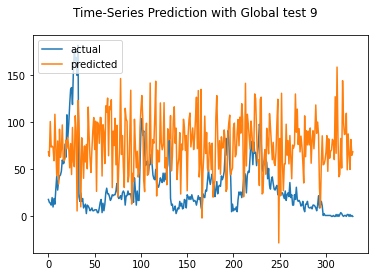

Test MAE: 41.926
Test RMSE: 50.557
Test sMAPE: 100.269
Test R Squared: -1.645
{'mae': 41.926018815510204, 'rmse': 50.557311029502905, 'smape': 100.2691480231501, 'r2': -1.6449041385631702}


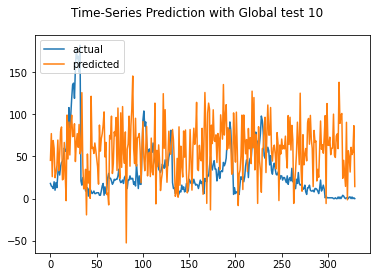

Test MAE: 38.323
Test RMSE: 48.178
Test sMAPE: 98.868
Test R Squared: -1.402
{'mae': 38.32261351536621, 'rmse': 48.17844270106767, 'smape': 98.86788990474258, 'r2': -1.4018590486117275}


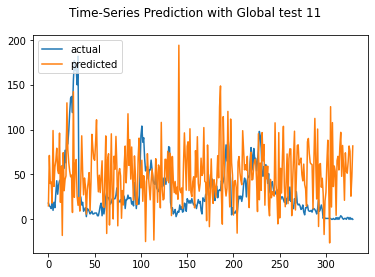

Test MAE: 44.178
Test RMSE: 53.543
Test sMAPE: 101.304
Test R Squared: -1.967
{'mae': 44.177875169479485, 'rmse': 53.54322077346211, 'smape': 101.30405499294072, 'r2': -1.9665453030771292}


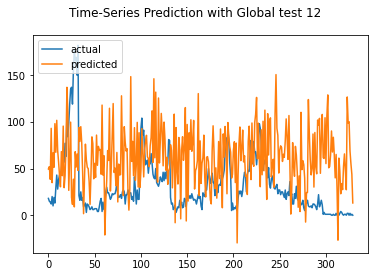

Test MAE: 71.580
Test RMSE: 81.766
Test sMAPE: 117.512
Test R Squared: -5.918
{'mae': 71.58028939673395, 'rmse': 81.7658303676396, 'smape': 117.51208605398843, 'r2': -5.918081990048145}


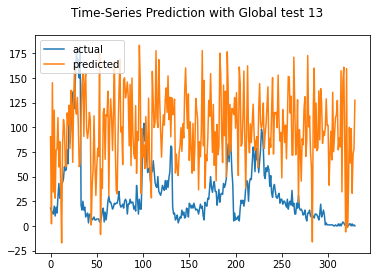

Test MAE: 38.457
Test RMSE: 48.419
Test sMAPE: 102.230
Test R Squared: -1.426
{'mae': 38.45728920029872, 'rmse': 48.419303733985686, 'smape': 102.23015059430935, 'r2': -1.425934561114064}


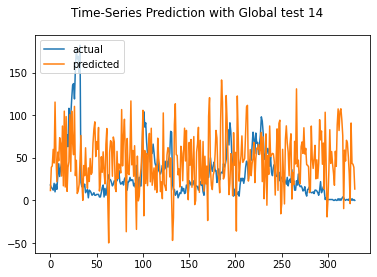

Test MAE: 37.250
Test RMSE: 48.425
Test sMAPE: 109.745
Test R Squared: -1.426
{'mae': 37.250144398031814, 'rmse': 48.42487864294326, 'smape': 109.74536263542814, 'r2': -1.4264932284990675}


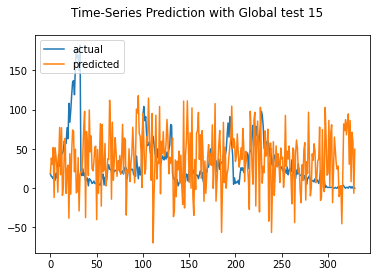

Test MAE: 46.162
Test RMSE: 55.632
Test sMAPE: 104.057
Test R Squared: -2.202
{'mae': 46.16172272310112, 'rmse': 55.631711051117634, 'smape': 104.05711488305771, 'r2': -2.2024830288726145}


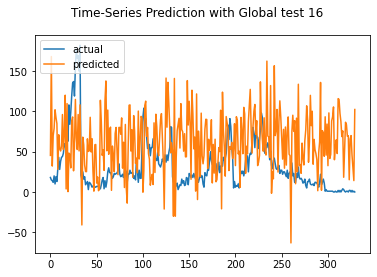

Test MAE: 46.177
Test RMSE: 53.902
Test sMAPE: 102.124
Test R Squared: -2.006
{'mae': 46.17721957997842, 'rmse': 53.90219826383026, 'smape': 102.12366064213612, 'r2': -2.006456717835101}


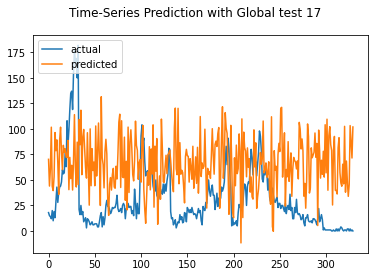

Test MAE: 51.756
Test RMSE: 59.358
Test sMAPE: 106.861
Test R Squared: -2.646
{'mae': 51.755757331125665, 'rmse': 59.35795543279862, 'smape': 106.86141840012338, 'r2': -2.6458589974678586}


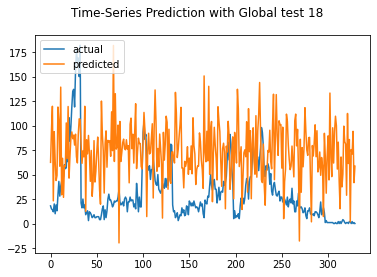

Test MAE: 64.436
Test RMSE: 74.245
Test sMAPE: 113.583
Test R Squared: -4.704
{'mae': 64.4361225120949, 'rmse': 74.24481605901438, 'smape': 113.582580526529, 'r2': -4.703931126922749}


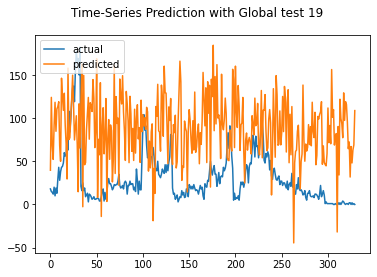

Test MAE: 50.919
Test RMSE: 59.514
Test sMAPE: 104.675
Test R Squared: -2.665
{'mae': 50.919475330005994, 'rmse': 59.514143184052, 'smape': 104.67487663174693, 'r2': -2.6650708349314725}


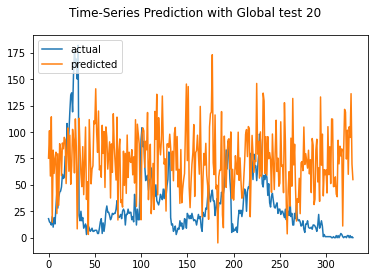

Test MAE: 36.041
Test RMSE: 46.488
Test sMAPE: 101.042
Test R Squared: -1.236
{'mae': 36.04088685241612, 'rmse': 46.488198371169815, 'smape': 101.04191376187933, 'r2': -1.2362864529205617}


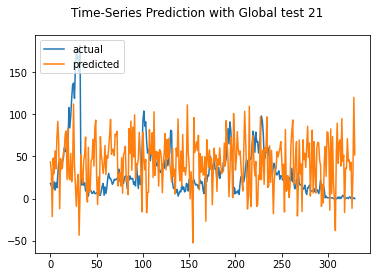

Test MAE: 57.487
Test RMSE: 66.104
Test sMAPE: 108.581
Test R Squared: -3.522
{'mae': 57.48659889806401, 'rmse': 66.10370510751058, 'smape': 108.58067495419716, 'r2': -3.5216152649126364}


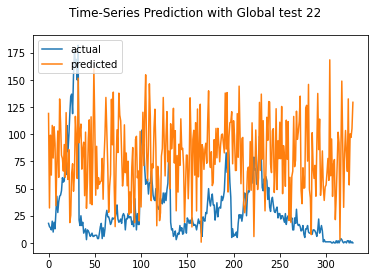

Test MAE: 36.509
Test RMSE: 44.322
Test sMAPE: 97.275
Test R Squared: -1.033
{'mae': 36.50898663058425, 'rmse': 44.32199876675728, 'smape': 97.27498273556053, 'r2': -1.0327345848895009}


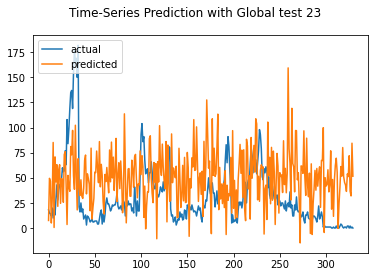

Test MAE: 58.477
Test RMSE: 65.807
Test sMAPE: 109.177
Test R Squared: -3.481
{'mae': 58.476967011076034, 'rmse': 65.80721389109227, 'smape': 109.17731155004232, 'r2': -3.481145136768773}


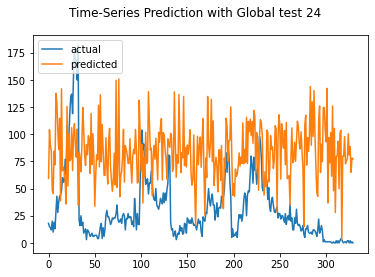

Test MAE: 57.247
Test RMSE: 65.732
Test sMAPE: 109.149
Test R Squared: -3.471
{'mae': 57.246587724396676, 'rmse': 65.73234928711166, 'smape': 109.14864293296189, 'r2': -3.470955119299025}


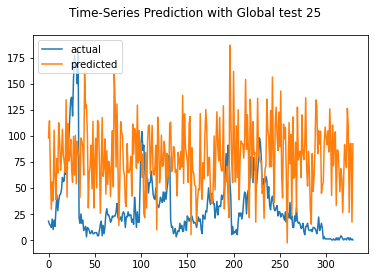

Test MAE: 50.921
Test RMSE: 59.622
Test sMAPE: 106.913
Test R Squared: -2.678
{'mae': 50.92112330812397, 'rmse': 59.622485871871774, 'smape': 106.91307272075404, 'r2': -2.6784271579847463}


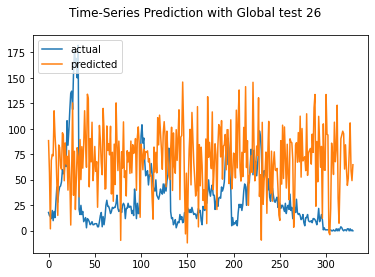

Test MAE: 53.311
Test RMSE: 61.743
Test sMAPE: 106.357
Test R Squared: -2.945
{'mae': 53.310570437980424, 'rmse': 61.74307799966803, 'smape': 106.35744559113564, 'r2': -2.944741542357052}


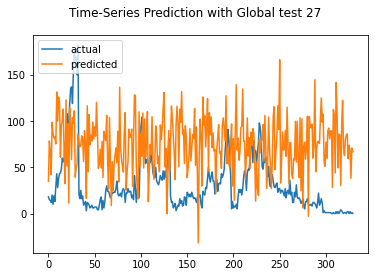

Test MAE: 48.133
Test RMSE: 58.389
Test sMAPE: 105.421
Test R Squared: -2.528
{'mae': 48.133053129008324, 'rmse': 58.388586820926406, 'smape': 105.42131079371545, 'r2': -2.527751051328977}


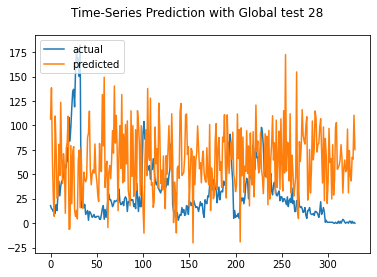

Test MAE: 39.765
Test RMSE: 48.718
Test sMAPE: 100.366
Test R Squared: -1.456
{'mae': 39.764688024737616, 'rmse': 48.718058609542574, 'smape': 100.36562648391228, 'r2': -1.45596372981039}


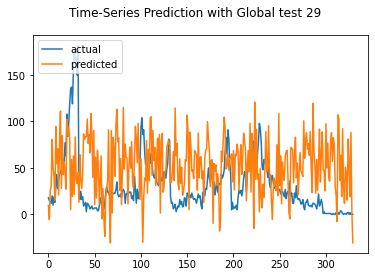

Test MAE: 50.511
Test RMSE: 58.106
Test sMAPE: 104.237
Test R Squared: -2.494
{'mae': 50.510968164964154, 'rmse': 58.10608547198106, 'smape': 104.23711708632199, 'r2': -2.493697015266703}


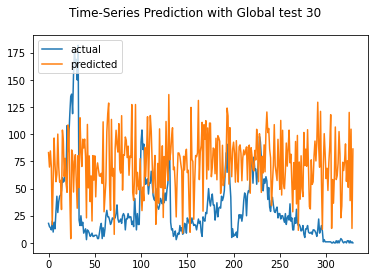

Test MAE: 44.673
Test RMSE: 54.725
Test sMAPE: 105.519
Test R Squared: -2.099
{'mae': 44.673371986548105, 'rmse': 54.72505259900068, 'smape': 105.51923855665294, 'r2': -2.0989486286539116}


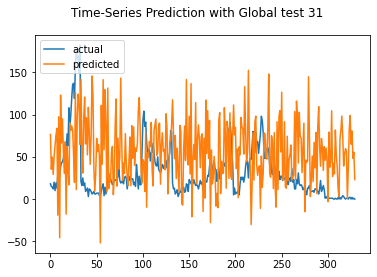

Test MAE: 57.865
Test RMSE: 67.091
Test sMAPE: 109.369
Test R Squared: -3.658
{'mae': 57.86498098373413, 'rmse': 67.09110972401945, 'smape': 109.36899253444554, 'r2': -3.657704719481022}


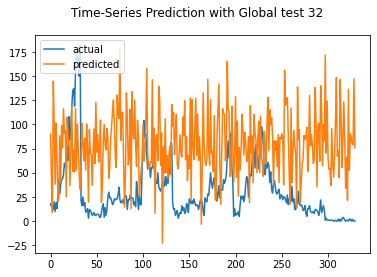

Test MAE: 38.271
Test RMSE: 47.221
Test sMAPE: 97.666
Test R Squared: -1.307
{'mae': 38.27088688034, 'rmse': 47.22138356535715, 'smape': 97.66626159199991, 'r2': -1.307381556020855}


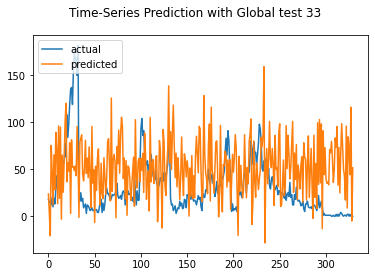

Test MAE: 42.804
Test RMSE: 53.846
Test sMAPE: 102.377
Test R Squared: -2.000
{'mae': 42.80359736103, 'rmse': 53.8455899735011, 'smape': 102.37696953947814, 'r2': -2.0001452495484657}


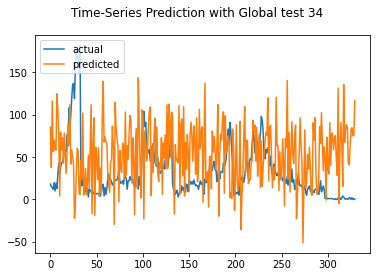

Test MAE: 61.615
Test RMSE: 71.142
Test sMAPE: 115.062
Test R Squared: -4.237
{'mae': 61.615293030485965, 'rmse': 71.14160302810495, 'smape': 115.0616449243573, 'r2': -4.237081053111141}


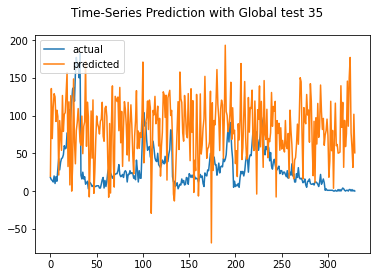

Test MAE: 39.620
Test RMSE: 50.521
Test sMAPE: 104.272
Test R Squared: -1.641
{'mae': 39.61973758177324, 'rmse': 50.520949134601544, 'smape': 104.27197196384932, 'r2': -1.6411009639379084}


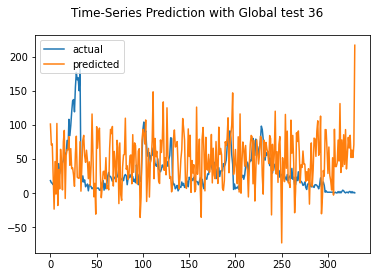

Test MAE: 64.079
Test RMSE: 72.641
Test sMAPE: 113.721
Test R Squared: -4.460
{'mae': 64.07943621006879, 'rmse': 72.64071725408456, 'smape': 113.72079031636311, 'r2': -4.4601207749875655}


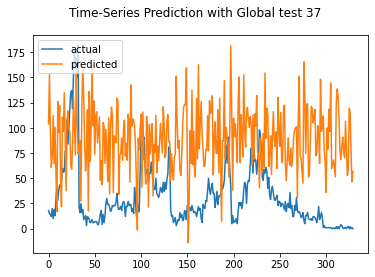

Test MAE: 69.147
Test RMSE: 77.209
Test sMAPE: 115.793
Test R Squared: -5.169
{'mae': 69.14694464134448, 'rmse': 77.20935105722216, 'smape': 115.79325660362507, 'r2': -5.1685317742062855}


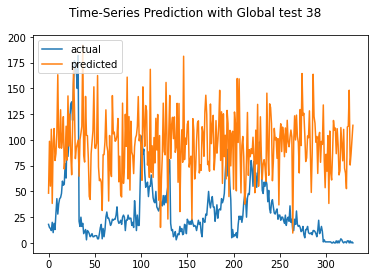

Test MAE: 41.358
Test RMSE: 50.680
Test sMAPE: 98.716
Test R Squared: -1.658
{'mae': 41.35794037327622, 'rmse': 50.67964053455994, 'smape': 98.71600655110508, 'r2': -1.6577189517514204}


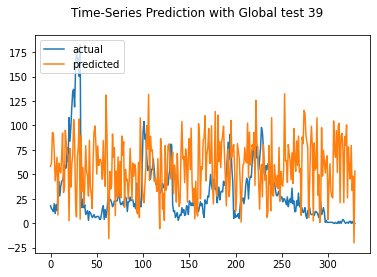

Test MAE: 44.155
Test RMSE: 53.563
Test sMAPE: 101.687
Test R Squared: -1.969
{'mae': 44.15504650292974, 'rmse': 53.56259572714834, 'smape': 101.68654687636001, 'r2': -1.9686926179444386}


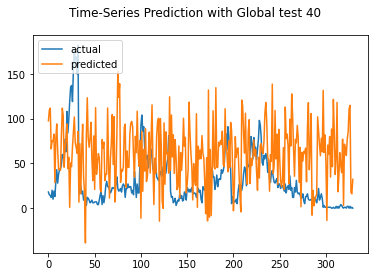

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 42.145
Test RMSE: 53.668
Test sMAPE: 107.235
Test R Squared: -1.980
{'mae': 42.14452871120337, 'rmse': 53.66804677860681, 'smape': 107.23475883774319, 'r2': -1.9803933174040833}


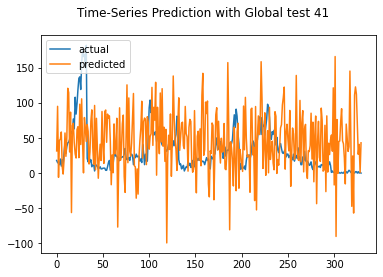

Test MAE: 35.552
Test RMSE: 46.258
Test sMAPE: 100.844
Test R Squared: -1.214
{'mae': 35.55200578136878, 'rmse': 46.25805160229546, 'smape': 100.84397597528557, 'r2': -1.2141991217740098}


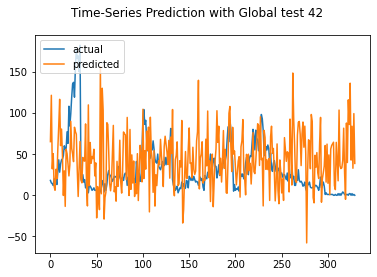

Test MAE: 52.172
Test RMSE: 63.256
Test sMAPE: 108.557
Test R Squared: -3.140
{'mae': 52.17212949738358, 'rmse': 63.25552336221814, 'smape': 108.55672793767839, 'r2': -3.1403676662178084}


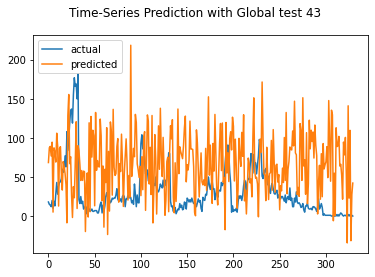

Test MAE: 33.133
Test RMSE: 43.996
Test sMAPE: 101.098
Test R Squared: -1.003
{'mae': 33.132782981522155, 'rmse': 43.99603369598252, 'smape': 101.09784776043358, 'r2': -1.0029451371388722}


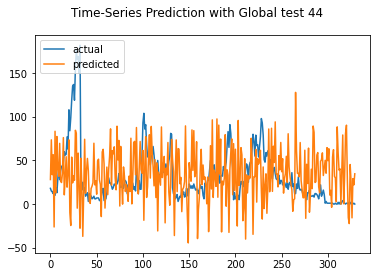

Test MAE: 43.097
Test RMSE: 51.786
Test sMAPE: 98.681
Test R Squared: -1.775
{'mae': 43.09721925186388, 'rmse': 51.7864807040609, 'smape': 98.68070261695874, 'r2': -1.7750754684444847}


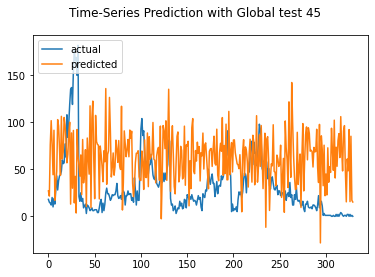

Test MAE: 37.445
Test RMSE: 46.918
Test sMAPE: 102.436
Test R Squared: -1.278
{'mae': 37.44506909016407, 'rmse': 46.917502046759864, 'smape': 102.43589636662139, 'r2': -1.277779945328744}


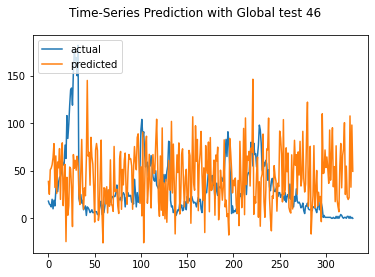

Test MAE: 37.594
Test RMSE: 47.654
Test sMAPE: 97.653
Test R Squared: -1.350
{'mae': 37.593920864119674, 'rmse': 47.65418250767598, 'smape': 97.6528353947962, 'r2': -1.34987114916422}


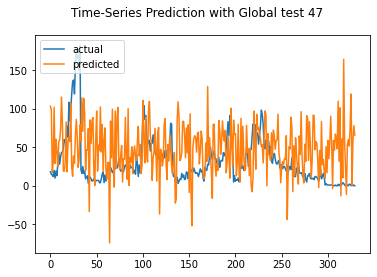

Test MAE: 44.516
Test RMSE: 55.411
Test sMAPE: 103.672
Test R Squared: -2.177
{'mae': 44.51553827614495, 'rmse': 55.41107309054782, 'smape': 103.67194888327563, 'r2': -2.1771310083138706}


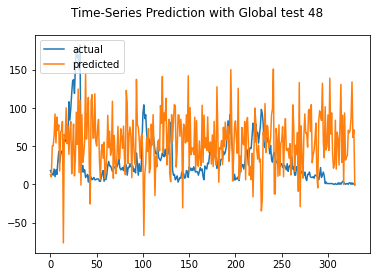

Test MAE: 39.324
Test RMSE: 48.034
Test sMAPE: 103.022
Test R Squared: -1.387
{'mae': 39.323844850063324, 'rmse': 48.03367018323504, 'smape': 103.02199897648997, 'r2': -1.3874459326303255}


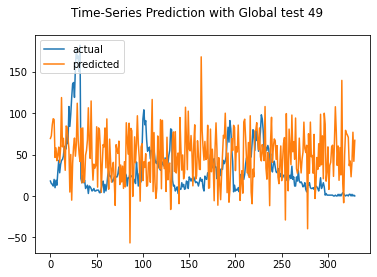

Test MAE: 43.834
Test RMSE: 52.710
Test sMAPE: 100.521
Test R Squared: -1.875
{'mae': 43.83439839139129, 'rmse': 52.710100627796706, 'smape': 100.52113001654692, 'r2': -1.8749460035451144}


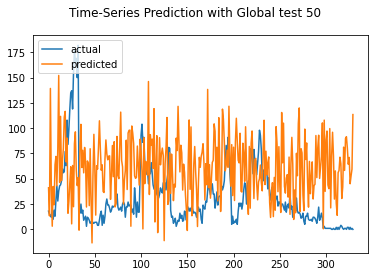

Test MAE: 48.492
Test RMSE: 58.717
Test sMAPE: 106.387
Test R Squared: -2.568
{'mae': 48.49234285616514, 'rmse': 58.71733224439754, 'smape': 106.38670338971086, 'r2': -2.567587495325595}


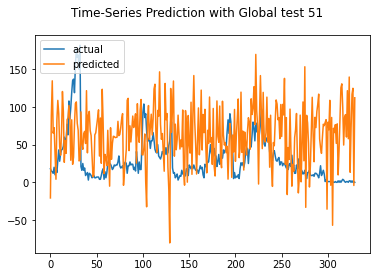

Test MAE: 68.185
Test RMSE: 76.769
Test sMAPE: 114.880
Test R Squared: -5.098
{'mae': 68.18538469545769, 'rmse': 76.7693837281848, 'smape': 114.88032013799119, 'r2': -5.0984309415678055}


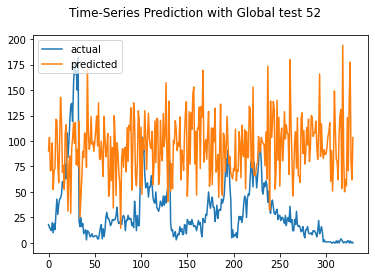

Test MAE: 58.384
Test RMSE: 65.693
Test sMAPE: 109.306
Test R Squared: -3.466
{'mae': 58.38413197344, 'rmse': 65.69253943013473, 'smape': 109.30612246132942, 'r2': -3.4655412192084007}


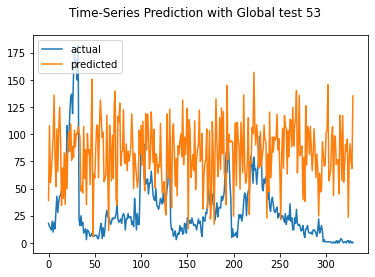

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 47.021
Test RMSE: 60.498
Test sMAPE: 115.384
Test R Squared: -2.787
{'mae': 47.021405431537914, 'rmse': 60.49763877994568, 'smape': 115.38421335826813, 'r2': -2.7872053199251927}


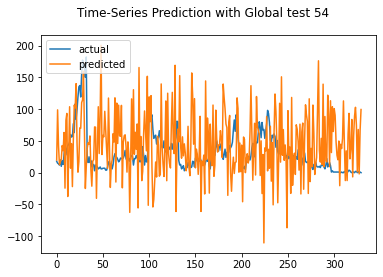

Test MAE: 54.891
Test RMSE: 63.587
Test sMAPE: 106.498
Test R Squared: -3.184
{'mae': 54.89132989121206, 'rmse': 63.58657236732652, 'smape': 106.49790878942723, 'r2': -3.183818458290311}


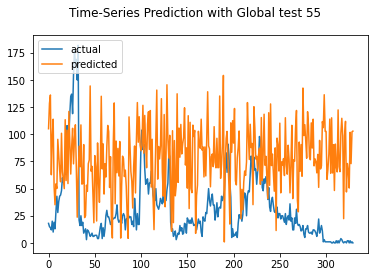

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 43.561
Test RMSE: 53.883
Test sMAPE: 107.780
Test R Squared: -2.004
{'mae': 43.56087277612903, 'rmse': 53.88257169001536, 'smape': 107.77951191273738, 'r2': -2.004267727254307}


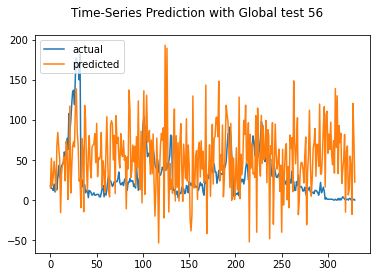

Test MAE: 61.186
Test RMSE: 69.650
Test sMAPE: 112.521
Test R Squared: -4.020
{'mae': 61.18580581780636, 'rmse': 69.65014993821552, 'smape': 112.52075728436162, 'r2': -4.019796518520929}


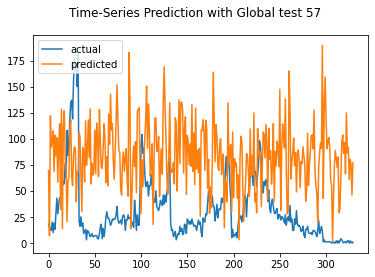

Test MAE: 52.110
Test RMSE: 61.063
Test sMAPE: 105.567
Test R Squared: -2.858
{'mae': 52.10974161968087, 'rmse': 61.06257391608165, 'smape': 105.56704399177097, 'r2': -2.8582664385058787}


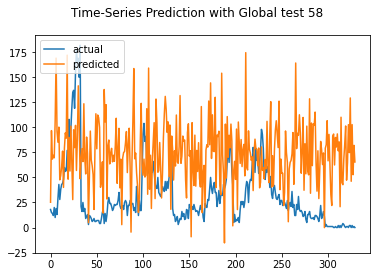

Test MAE: 54.980
Test RMSE: 64.119
Test sMAPE: 107.117
Test R Squared: -3.254
{'mae': 54.979726946353914, 'rmse': 64.11907994479877, 'smape': 107.11653035856868, 'r2': -3.2541868967118903}


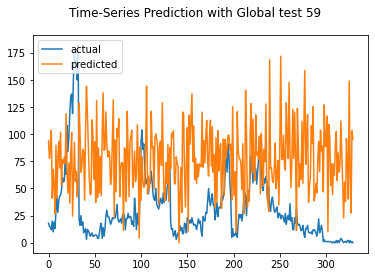

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 41.154
Test RMSE: 52.314
Test sMAPE: 107.211
Test R Squared: -1.832
{'mae': 41.154158060659064, 'rmse': 52.31383058938318, 'smape': 107.21053383636188, 'r2': -1.8318812953033574}


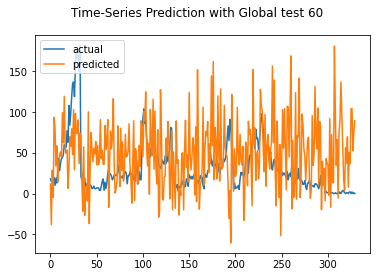

Test MAE: 39.088
Test RMSE: 49.602
Test sMAPE: 115.270
Test R Squared: -1.546
{'mae': 39.08835902828159, 'rmse': 49.60203250917163, 'smape': 115.27005206791624, 'r2': -1.5458976896757592}


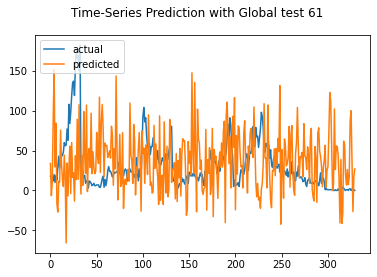

Test MAE: 50.617
Test RMSE: 59.074
Test sMAPE: 102.513
Test R Squared: -2.611
{'mae': 50.617425016923384, 'rmse': 59.07387365562258, 'smape': 102.51263017484867, 'r2': -2.611045006322208}


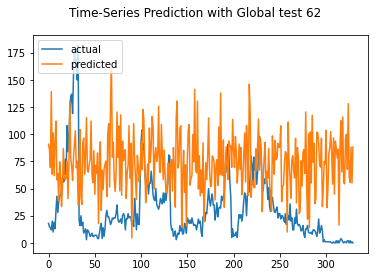

Test MAE: 41.390
Test RMSE: 51.196
Test sMAPE: 101.101
Test R Squared: -1.712
{'mae': 41.389815072579815, 'rmse': 51.19642268254152, 'smape': 101.101469483551, 'r2': -1.712197014882611}


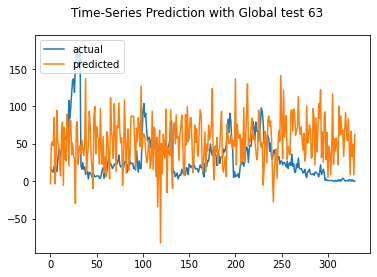

Test MAE: 60.459
Test RMSE: 71.114
Test sMAPE: 109.438
Test R Squared: -4.233
{'mae': 60.45938063390327, 'rmse': 71.11402336476758, 'smape': 109.43754739363256, 'r2': -4.233021292604355}


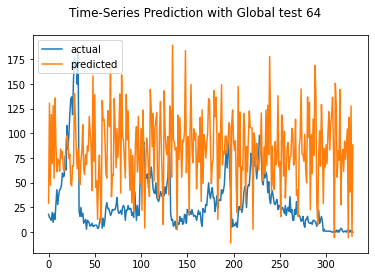

Test MAE: 36.314
Test RMSE: 44.663
Test sMAPE: 99.464
Test R Squared: -1.064
{'mae': 36.31400836308797, 'rmse': 44.6627813101086, 'smape': 99.4641936972034, 'r2': -1.0641132939840596}


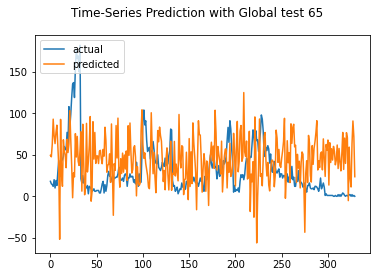

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 48.190
Test RMSE: 59.620
Test sMAPE: 118.394
Test R Squared: -2.678
{'mae': 48.190300366643704, 'rmse': 59.62010166411198, 'smape': 118.39372478024221, 'r2': -2.6781329750403806}


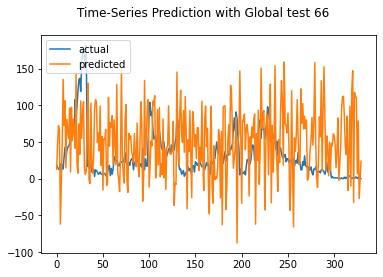

Test MAE: 47.886
Test RMSE: 56.222
Test sMAPE: 101.952
Test R Squared: -2.271
{'mae': 47.88557328058012, 'rmse': 56.22249895994769, 'smape': 101.95162635196832, 'r2': -2.270862531088589}


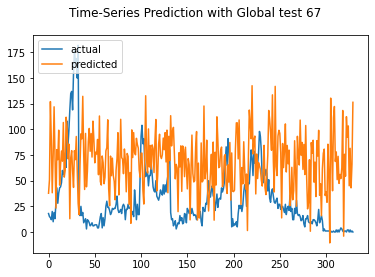

Test MAE: 43.385
Test RMSE: 53.774
Test sMAPE: 105.351
Test R Squared: -1.992
{'mae': 43.38451366316188, 'rmse': 53.77362238088239, 'smape': 105.3509916942045, 'r2': -1.9921308906652921}


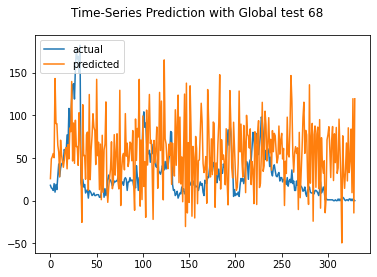

Test MAE: 51.343
Test RMSE: 61.299
Test sMAPE: 105.146
Test R Squared: -2.888
{'mae': 51.34315886894862, 'rmse': 61.29884956047925, 'smape': 105.1462936664451, 'r2': -2.888182573110085}


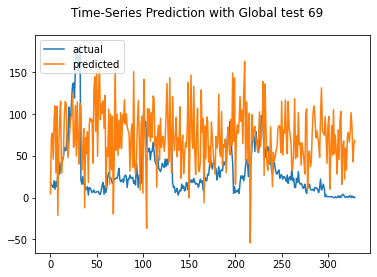

Test MAE: 40.931
Test RMSE: 49.671
Test sMAPE: 98.272
Test R Squared: -1.553
{'mae': 40.93091116312778, 'rmse': 49.67132065557485, 'smape': 98.2721312127138, 'r2': -1.5530152906373749}


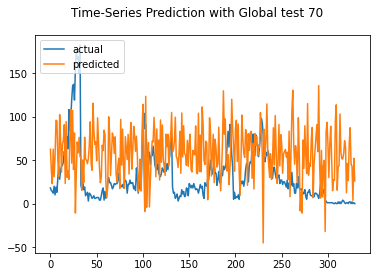

Test MAE: 58.775
Test RMSE: 67.831
Test sMAPE: 108.777
Test R Squared: -3.761
{'mae': 58.77496382973411, 'rmse': 67.83106139255386, 'smape': 108.77697547083991, 'r2': -3.761011464147119}


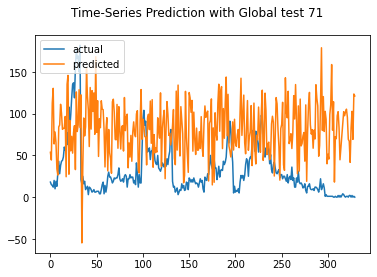

Test MAE: 42.065
Test RMSE: 51.064
Test sMAPE: 101.778
Test R Squared: -1.698
{'mae': 42.06478486313964, 'rmse': 51.06355735323232, 'smape': 101.77767174378079, 'r2': -1.698137854879406}


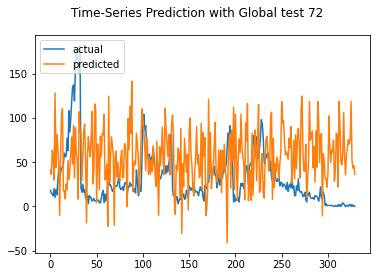

Test MAE: 45.040
Test RMSE: 53.806
Test sMAPE: 102.247
Test R Squared: -1.996
{'mae': 45.03979071559328, 'rmse': 53.806484234684504, 'smape': 102.24675729446643, 'r2': -1.9957890787531016}


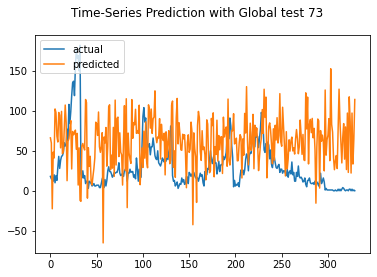

Test MAE: 43.948
Test RMSE: 55.266
Test sMAPE: 104.479
Test R Squared: -2.161
{'mae': 43.948321134213245, 'rmse': 55.266183055877164, 'smape': 104.47863414585207, 'r2': -2.1605374738450367}


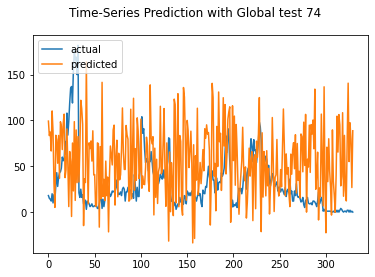

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 40.200
Test RMSE: 51.315
Test sMAPE: 115.806
Test R Squared: -1.725
{'mae': 40.200486941229215, 'rmse': 51.31452935009242, 'smape': 115.80614349646602, 'r2': -1.724725157376318}


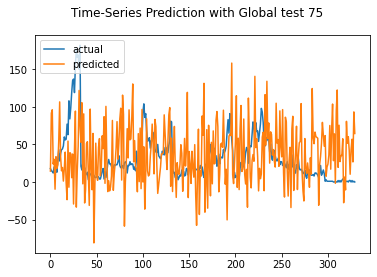

Test MAE: 39.470
Test RMSE: 49.616
Test sMAPE: 97.662
Test R Squared: -1.547
{'mae': 39.47037400729729, 'rmse': 49.615892002235455, 'smape': 97.66175263995348, 'r2': -1.5473206064041083}


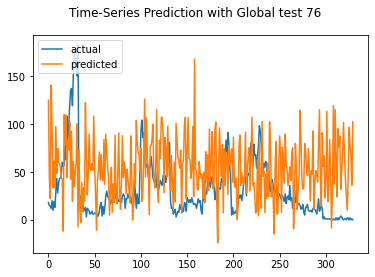

Test MAE: 40.213
Test RMSE: 49.376
Test sMAPE: 98.131
Test R Squared: -1.523
{'mae': 40.213485927292794, 'rmse': 49.37563187055645, 'smape': 98.13066253228249, 'r2': -1.522710033580469}


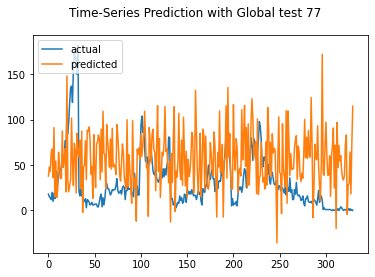

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 41.424
Test RMSE: 51.252
Test sMAPE: 104.649
Test R Squared: -1.718
{'mae': 41.42386474175887, 'rmse': 51.25206162021685, 'smape': 104.64930435549388, 'r2': -1.718095308235931}


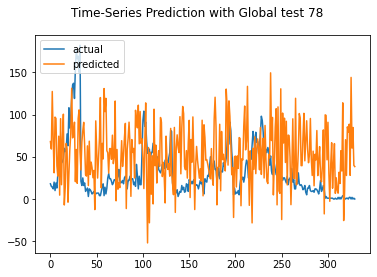

Test MAE: 55.451
Test RMSE: 64.001
Test sMAPE: 108.095
Test R Squared: -3.239
{'mae': 55.451220936666836, 'rmse': 64.00099905890048, 'smape': 108.09481169993907, 'r2': -3.238532411083681}


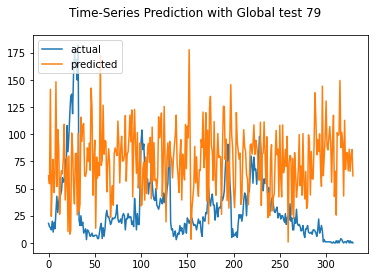

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 48.925
Test RMSE: 60.695
Test sMAPE: 116.322
Test R Squared: -2.812
{'mae': 48.92471462009531, 'rmse': 60.695070258525035, 'smape': 116.32185750547201, 'r2': -2.811964422158745}


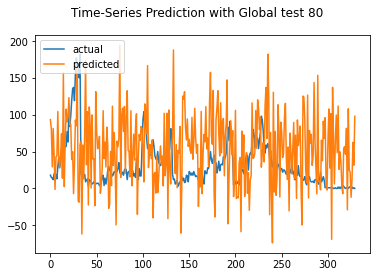

Test MAE: 53.118
Test RMSE: 62.170
Test sMAPE: 107.273
Test R Squared: -2.999
{'mae': 53.1178629712625, 'rmse': 62.17013128073464, 'smape': 107.27252277511727, 'r2': -2.9994987974835965}


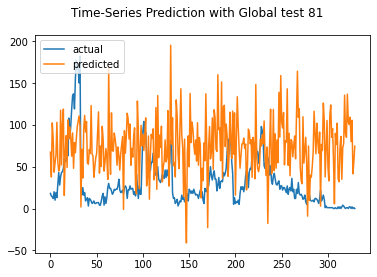

Test MAE: 37.354
Test RMSE: 47.158
Test sMAPE: 102.826
Test R Squared: -1.301
{'mae': 37.35385174697096, 'rmse': 47.15826264596614, 'smape': 102.8257030280384, 'r2': -1.301217115554819}


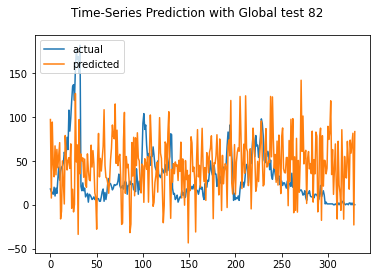

Test MAE: 40.495
Test RMSE: 49.082
Test sMAPE: 102.159
Test R Squared: -1.493
{'mae': 40.494847839890106, 'rmse': 49.0818509497489, 'smape': 102.15895998611319, 'r2': -1.4927795097507612}


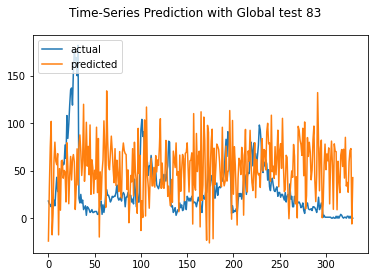

Test MAE: 42.366
Test RMSE: 50.400
Test sMAPE: 97.531
Test R Squared: -1.628
{'mae': 42.365771530794376, 'rmse': 50.39985022172782, 'smape': 97.53148394361564, 'r2': -1.6284546800191135}


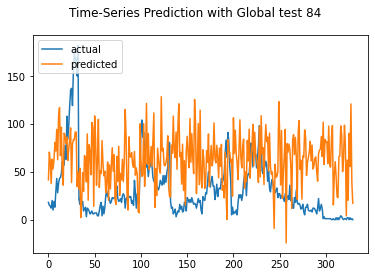

Test MAE: 65.058
Test RMSE: 73.896
Test sMAPE: 116.530
Test R Squared: -4.650
{'mae': 65.05783834638018, 'rmse': 73.89592839388956, 'smape': 116.52975623491808, 'r2': -4.650449804216159}


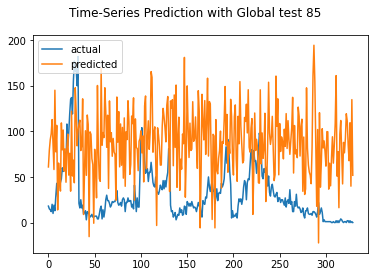

Test MAE: 36.468
Test RMSE: 44.813
Test sMAPE: 98.002
Test R Squared: -1.078
{'mae': 36.4680173897382, 'rmse': 44.813119577407, 'smape': 98.00221176537936, 'r2': -1.078032601252343}


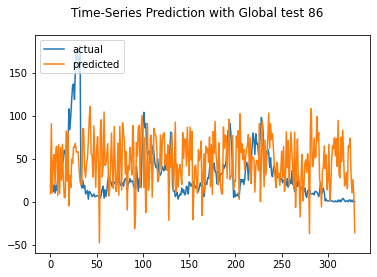

Test MAE: 52.170
Test RMSE: 62.289
Test sMAPE: 106.694
Test R Squared: -3.015
{'mae': 52.169856042211705, 'rmse': 62.2892975938415, 'smape': 106.6938667119104, 'r2': -3.01484579095247}


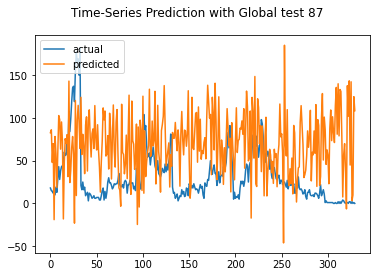

Test MAE: 49.608
Test RMSE: 60.074
Test sMAPE: 103.248
Test R Squared: -2.734
{'mae': 49.60771014473655, 'rmse': 60.07373162363757, 'smape': 103.24845397883244, 'r2': -2.734317343928039}


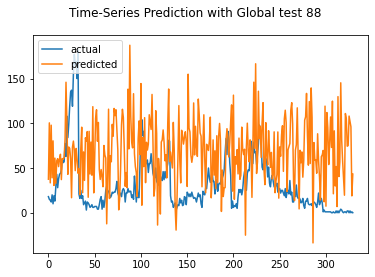

Test MAE: 31.430
Test RMSE: 40.831
Test sMAPE: 100.058
Test R Squared: -0.725
{'mae': 31.43042472600937, 'rmse': 40.830711537791366, 'smape': 100.05752646112543, 'r2': -0.7251064467401565}


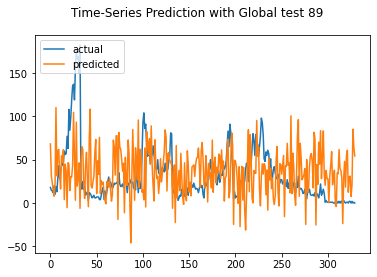

Test MAE: 68.366
Test RMSE: 76.472
Test sMAPE: 115.893
Test R Squared: -5.051
{'mae': 68.36636308323253, 'rmse': 76.47192627362892, 'smape': 115.89251167822789, 'r2': -5.051263457130811}


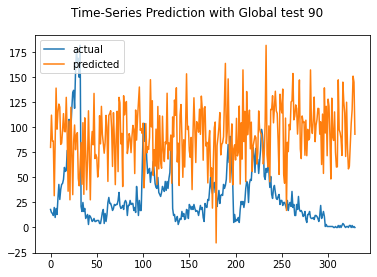

Test MAE: 50.412
Test RMSE: 59.061
Test sMAPE: 103.152
Test R Squared: -2.609
{'mae': 50.411919205658364, 'rmse': 59.060962362798705, 'smape': 103.15166050167721, 'r2': -2.609466705744983}


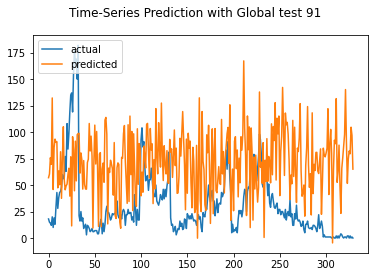

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 52.873
Test RMSE: 67.228
Test sMAPE: 111.793
Test R Squared: -3.677
{'mae': 52.872962852860944, 'rmse': 67.22835895799493, 'smape': 111.79315935431016, 'r2': -3.6767808768329298}


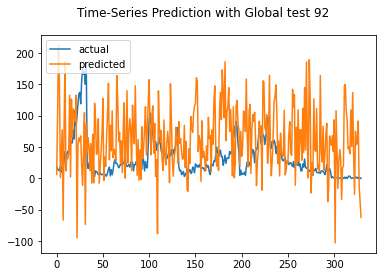

Test MAE: 60.368
Test RMSE: 68.589
Test sMAPE: 111.094
Test R Squared: -3.868
{'mae': 60.368325768095076, 'rmse': 68.5894317948051, 'smape': 111.09368316504172, 'r2': -3.868065487034177}


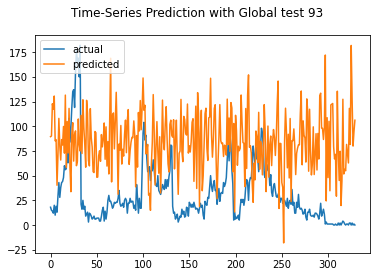

Test MAE: 52.547
Test RMSE: 60.520
Test sMAPE: 108.078
Test R Squared: -2.790
{'mae': 52.54733180999756, 'rmse': 60.5197211346167, 'smape': 108.07765161771933, 'r2': -2.789970574101015}


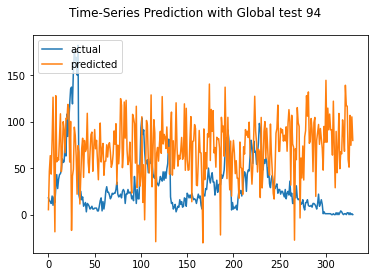

Test MAE: 47.637
Test RMSE: 57.465
Test sMAPE: 104.199
Test R Squared: -2.417
{'mae': 47.63749648711898, 'rmse': 57.465168569681495, 'smape': 104.19918368873365, 'r2': -2.417050299169314}


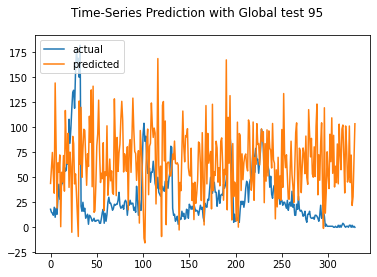

Test MAE: 47.921
Test RMSE: 57.705
Test sMAPE: 102.350
Test R Squared: -2.446
{'mae': 47.92094644723517, 'rmse': 57.70515427163216, 'smape': 102.35004631217001, 'r2': -2.445650425644066}


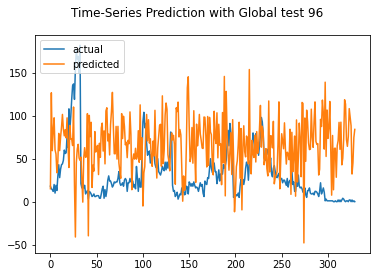

Test MAE: 61.530
Test RMSE: 70.000
Test sMAPE: 111.725
Test R Squared: -4.070
{'mae': 61.52983634038405, 'rmse': 70.00030918367135, 'smape': 111.725012828755, 'r2': -4.070396454490616}


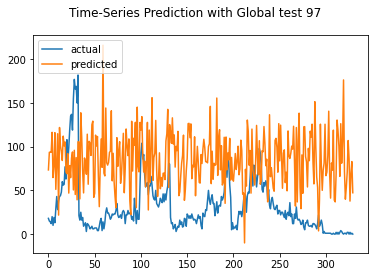

Test MAE: 45.645
Test RMSE: 53.562
Test sMAPE: 104.124
Test R Squared: -1.969
{'mae': 45.64506387855067, 'rmse': 53.56217399485089, 'smape': 104.12417240269338, 'r2': -1.9686458693277094}


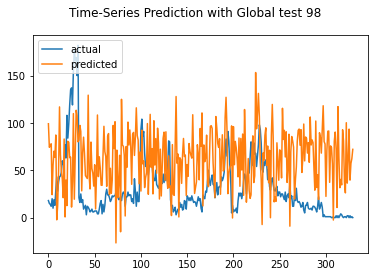

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 37.197
Test RMSE: 48.252
Test sMAPE: 101.609
Test R Squared: -1.409
{'mae': 37.19698263244195, 'rmse': 48.25232544520934, 'smape': 101.60867998354732, 'r2': -1.4092313086503068}


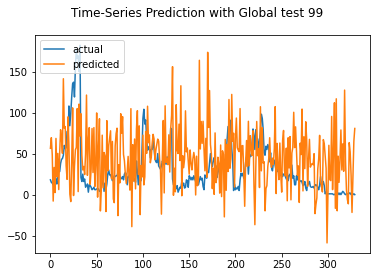

rmse : average=57.130, std=8.726
mae : average=47.667, std=8.993
smape : average=105.585, std=5.289
r2 : average=-2.456, std=1.083


([57.12992549768618, 8.72581212582107],
 [47.66677061361797, 8.992831962254074],
 [105.58500987016845, 5.288585803596688],
 [-2.4560843351086157, 1.0825100533643397])

In [14]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]


calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')